## 状態空間モデルで時系列予測を行う（pystan）

In [1]:
%load_ext lab_black

In [2]:
import arviz
import matplotlib.pyplot as plt

# 必要なライブラリーのインポート
import numpy as np
import pandas as pd
import pystan
import seaborn as sns
from numpy.random import *
from scipy import stats

%matplotlib inline

import warnings

warnings.filterwarnings("ignore")

# グラフを横長にする
from matplotlib import rcParams

rcParams["figure.figsize"] = 10, 6
sns.set()

# 表示する図表の設定
plt.rcParams["font.size"] = 12
plt.rcParams["axes.linewidth"] = 1.2
plt.rcParams["axes.grid"] = True
plt.rcParams["axes.edgecolor"] = "black"
plt.rcParams["axes.facecolor"] = "w"
plt.rcParams["grid.linestyle"] = "-"
plt.rcParams["grid.linewidth"] = 0.3
plt.rcParams["grid.color"] = "grey"
plt.rcParams["figure.figsize"] = (8, 4)

# 可視化に用いる色の設定
maincolor = "#70B145"

In [3]:
# データの読み込み
# https://stat.ethz.ch/R-manual/R-devel/library/datasets/html/AirPassengers.html
df = pd.read_csv("../../data/AirPassengers.csv")

# float型に変換
# df['#Passengers'] = df['#Passengers'].astype('float64')
df = df.rename(columns={"#Passengers": "Passengers"})

# datetime型にしてインデックスにする
# df.Month = pd.to_datetime(df.Month)
# df = df.set_index("Month")

# データの中身を確認
df.head()

,Month,Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


## ローカルレベルモデル

以下のローカルレベルモデルをStanでベイズ推定します。
\begin{align*}
y_t &= \mu_t + \epsilon_t, &\epsilon_t \sim N(0, \sigma_y^2) \\
\mu_t &= \mu_{t-1} + \eta_t,  &\eta_t \sim N(0, \sigma_{\mu}^2)
\end{align*}

In [4]:
local_level = """
data {
    int<lower=0> T; // number of learning points
    int<lower=0> M; // number of predict points
    real Y[T]; // observations
}

parameters {
    real mu[T]; // trend
    real<lower=0> s_y; // sd of observations
    real<lower=0> s_mu; // sd of trend
}

transformed parameters {
    real y_hat[T]; // prediction

    for(t in 1:T) {
        y_hat[t] = mu[t];
    }
}

model {
    for(t in 1:T) {
        Y[t] ~ normal(mu[t], s_y);
    }
    for(t in 2:T) {
        mu[t] ~ normal(mu[t-1], s_mu);
    }
}

generated quantities {
    real mu_pred[T+M];
    real y_pred[T+M];

    for(t in 1:T) {
        mu_pred[t] = mu[t];
        y_pred[t] = y_hat[t];
    }
    for(t in (T+1):(T+M)) {
        mu_pred[t] = normal_rng(mu_pred[t-1], s_mu);
        y_pred[t] = mu_pred[t];
    }
}
"""

In [5]:
stan_model = pystan.StanModel(model_code=local_level)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_9bb0ebd023c1c9b55102b36db5240ae9 NOW.


In [6]:
y = df["Passengers"]
T = 137  # 学習期間
M = 7  # 予測期間

y_train = y[:-M]
y_test = y[-M:]

In [7]:
predict_dat = {"T": T, "M": M, "Y": y_train}

In [8]:
%%time
fit_local_level = stan_model.sampling(data=predict_dat, iter=6000, chains=2, seed=10)

CPU times: user 10.5 s, sys: 990 ms, total: 11.5 s
Wall time: 41.3 s


In [9]:
print(fit_local_level)

Inference for Stan model: anon_model_9bb0ebd023c1c9b55102b36db5240ae9.
2 chains, each with iter=6000; warmup=3000; thin=1; 
post-warmup draws per chain=3000, total post-warmup draws=6000.

               mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu[1]        112.05    0.03   3.01 105.71 110.96  112.0 113.12 118.66  11004    1.0
mu[2]         118.1    0.03   2.95 111.68 117.05 118.04 119.08 124.75   8912    1.0
mu[3]        131.86    0.03   3.12 124.93 130.84 131.96 132.98 138.59  10854    1.0
mu[4]        128.97    0.03   3.05  122.3 127.84 128.97 130.08 135.56  14031    1.0
mu[5]        121.23    0.03    3.0 115.23 120.06 121.06 122.19 128.28   7778    1.0
mu[6]        134.94    0.03   2.95 128.17  133.9 134.98 136.05 141.39  12204    1.0
mu[7]        147.82    0.03   3.04 140.83 146.79 147.93 148.96 154.25   8623    1.0
mu[8]        147.93    0.03   3.06 141.32 146.89 147.96 149.02  154.5   9844    1.0
mu[9]        135.96    0.03   3.05 128.86 134.95 135.98

In [10]:
# サンプリング結果の抽出
ms_local_level = fit_local_level.extract()
y_pred = ms_local_level["y_pred"].mean(axis=0)

In [11]:
quantile = [5, 95]
per_5_95 = np.percentile(ms_local_level["y_pred"], q=quantile, axis=0).T
colname = ["p5", "p95"]
df_pred = pd.DataFrame(per_5_95, columns=colname)
df_pred

,p5,p95
0,107.254001,116.822136
1,113.363103,122.875385
2,126.727208,136.624932
3,124.012226,133.958653
4,116.765345,126.148429
...,...,...
139,382.241857,561.449920
140,369.220368,576.030024
141,357.238360,587.696466
142,345.055774,599.745387


In [12]:
# 予測値を追加
df_pred["y_pred"] = y_pred

In [13]:
mu_hat = ms_local_level["mu"].mean(axis=0)

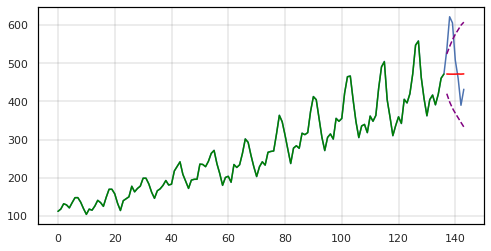

In [14]:
df.plot(y="Passengers", legend=False)  # 目的変数
plt.plot(df_pred[["p5", "p95"]][-7:], linestyle="dashed", color="purple")  # 予測区間
plt.plot(df_pred[["y_pred"]][-7:], color="red")  # 予測値
plt.plot(mu_hat, color="green")  # 状態
plt.show()

## ローカルレベルモデル(2階差分トレンド)

\begin{align*}
y_t &= \mu_t + \epsilon_t, \epsilon_t \sim N(0, \sigma_y^2) \\
\mu_t &= 2\mu_{t-1} - \mu_{t-2} + \eta_t,  \eta_t \sim N(0, \sigma_{\mu}^2)
\end{align*}

In [15]:
local_level_smooth = """
data {
    int<lower=0> T; // number of time points
    int<lower=0> M; // number of predict points
    real Y[T]; // observations
}

parameters {
    real mu[T]; // trend
    real<lower=0> s_y; // sd of observations
    real<lower=0> s_mu; // sd of trend
}

transformed parameters {
    real y_hat[T]; // prediction

    for(t in 1:T) {
        y_hat[t] = mu[t];
    }
}

model {
    for(t in 1:T) {
        Y[t] ~ normal(y_hat[t], s_y);
    }
    for(t in 3:T) {
        mu[t] ~ normal(2*mu[t-1] - mu[t-2], s_mu);
    }
}

generated quantities {
    real mu_pred[T+M];
    real y_pred[T+M];

    for(t in 1:T) {
        mu_pred[t] = mu[t];
        y_pred[t] = y_hat[t];
    }
    for(t in (T+1):(T+M)) {
        mu_pred[t] = normal_rng(2 * mu_pred[t-1] - mu_pred[t-2], s_mu);
        y_pred[t] = mu_pred[t];
    }
}
"""

In [16]:
stan_model = pystan.StanModel(model_code=local_level_smooth)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_f8e2075ff8b7d910b73b5adc01fd5ffb NOW.


In [17]:
%%time
fit_local_level_smooth = stan_model.sampling(
    data=predict_dat, iter=6000, chains=2, seed=10
)

CPU times: user 4.64 s, sys: 373 ms, total: 5.02 s
Wall time: 7min 5s


In [18]:
print(fit_local_level_smooth)

Inference for Stan model: anon_model_f8e2075ff8b7d910b73b5adc01fd5ffb.
2 chains, each with iter=6000; warmup=3000; thin=1; 
post-warmup draws per chain=3000, total post-warmup draws=6000.

               mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu[1]        108.56    1.29  12.67  86.78  99.57 107.49 116.03 137.25     96   1.02
mu[2]        110.56    1.25  12.08  89.83 101.94 109.58 117.72 137.95     94   1.02
mu[3]        112.55     1.2  11.52  92.75 104.35 111.61 119.43 138.79     92   1.02
mu[4]        114.54    1.15  10.99  95.54 106.67  113.7  121.2 139.74     91   1.02
mu[5]        116.54    1.11  10.48  98.45 109.06 115.73 122.92 140.65     90   1.02
mu[6]        118.54    1.06  10.01 101.15 111.27  117.8 124.63 141.73     89   1.01
mu[7]        120.53    1.01   9.56  103.9 113.61 119.88 126.37 142.65     89   1.01
mu[8]        122.54    0.97   9.14 106.45 115.95 121.94 128.03  143.4     89   1.01
mu[9]        124.54    0.93   8.74 108.95 118.22 124.01

In [19]:
# サンプリング結果の抽出
ms_local_level_smooth = fit_local_level_smooth.extract()
y_pred = ms_local_level_smooth["y_pred"].mean(axis=0)

In [20]:
quantile = [5, 95]
per_5_95 = np.percentile(ms_local_level_smooth["y_pred"], q=quantile, axis=0).T
colname = ["p5", "p95"]
df_pred = pd.DataFrame(per_5_95, columns=colname)
df_pred

,p5,p95
0,90.471238,131.079519
1,93.299857,131.991173
2,95.847293,133.019681
3,98.575306,134.084280
4,101.230752,135.103321
...,...,...
139,436.702655,478.523141
140,438.313050,482.427310
141,439.716643,486.314250
142,441.035632,489.771796


In [21]:
# 予測値を追加
df_pred["y_pred"] = y_pred

In [22]:
mu_hat = ms_local_level_smooth["mu"].mean(axis=0)

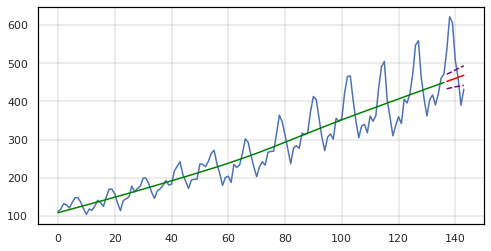

In [23]:
df.plot(y="Passengers", legend=False)  # 目的変数
plt.plot(df_pred[["p5", "p95"]][-7:], linestyle="dashed", color="purple")  # 予測区間
plt.plot(df_pred[["y_pred"]][-7:], color="red")  # 予測値
plt.plot(mu_hat, color="green")  # 状態
plt.show()

## ローカルレベルモデル+月別効果

\begin{align*}
y_t &= \mu_t + \gamma_t + \epsilon_t, &\epsilon_t \sim N(0, \sigma_y^2) \\
\mu_t &= 2\mu_{t-1} - \mu_{t-2} + \eta_t,  &\eta_t \sim N(0, \sigma_{\mu}^2)\\
\gamma_t &= -\sum_{l=1}^{11} \gamma_{t-l} + v_t, &v_t \sim N(0, \sigma_{\gamma}^2)
\end{align*}

In [24]:
local_level_smooth_season = """
data {
    int<lower=0> T; // number of time points
    int<lower=0> M; // number of predict points
    real Y[T]; // observations
}

parameters {
    real month_eff[T]; // month effect
    real mu[T]; // trend
    real<lower=0> s_y; // sd of observations
    real<lower=0> s_mu; // sd of trend
    real<lower=0> s_month; // sd of month effect
}

transformed parameters {
    real y_hat[T]; // prediction

    for(t in 1:T) {
        y_hat[t] = mu[t] + month_eff[t];
    }
}

model {
    for(t in 12:T) {
        month_eff[t] ~ normal(-sum(month_eff[(t-11):(t-1)]), s_month);
    }
    for(t in 1:T) {
        Y[t] ~ normal(y_hat[t], s_y);
    }
    for(t in 3:T) {
        mu[t] ~ normal((2 * mu[t-1] - mu[t-2]), s_mu);
    }
}

generated quantities {
    real month_eff_pred[T+M];
    real mu_pred[T+M];
    real y_pred[T+M];

    for(t in 1:T) {
        month_eff_pred[t] = month_eff[t];
        mu_pred[t] = mu[t];
        y_pred[t] = y_hat[t];
    }
    for(t in (T+1):(T+M)) {
        month_eff_pred[t] = normal_rng(-sum(month_eff_pred[(t-11):(t-1)]), s_month);
        mu_pred[t] = normal_rng(2 * mu_pred[t-1] - mu_pred[t-2], s_mu);
        y_pred[t] = mu_pred[t] + month_eff_pred[t];
    }
}
"""

In [25]:
stan_model = pystan.StanModel(model_code=local_level_smooth_season)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_22e985e390df597b4876aed6d3598b93 NOW.


In [26]:
%%time
fit_local_level_smooth_season = stan_model.sampling(
    data=predict_dat, iter=6000, chains=2, seed=10
)

CPU times: user 6.78 s, sys: 689 ms, total: 7.47 s
Wall time: 3min 40s


In [27]:
print(fit_local_level_smooth_season)

Inference for Stan model: anon_model_22e985e390df597b4876aed6d3598b93.
2 chains, each with iter=6000; warmup=3000; thin=1; 
post-warmup draws per chain=3000, total post-warmup draws=6000.

                      mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
month_eff[1]        -38.21    0.23    7.0 -51.69 -42.99 -38.25 -33.49  -24.4    924    1.0
month_eff[2]        -26.26    0.19   5.25 -36.58 -29.75 -26.27 -22.66 -16.25    729    1.0
month_eff[3]         -5.69    0.19   5.19 -16.03  -9.21  -5.58  -2.21   4.41    747    1.0
month_eff[4]         -0.13     0.2   5.18 -10.59  -3.52  -0.05   3.36   9.67    700    1.0
month_eff[5]          3.48    0.19   5.03  -6.46   0.09   3.64   6.84  13.31    700    1.0
month_eff[6]         29.87    0.19    5.1  20.29  26.39  29.82  33.28  40.02    734    1.0
month_eff[7]         49.86    0.21   5.37  39.44  46.24  49.79  53.35  61.14    670    1.0
month_eff[8]         46.75    0.19   5.23  36.78  43.13  46.64  50.17  57.44    748

In [28]:
# サンプリング結果の抽出
ms_local_level_smooth_season = fit_local_level_smooth_season.extract()
y_pred = ms_local_level_smooth_season["y_pred"].mean(axis=0)

In [29]:
quantile = [5, 95]
per_5_95 = np.percentile(ms_local_level["y_pred"], q=quantile, axis=0).T
colname = ["p5", "p95"]
df_pred = pd.DataFrame(per_5_95, columns=colname)
df_pred

,p5,p95
0,107.254001,116.822136
1,113.363103,122.875385
2,126.727208,136.624932
3,124.012226,133.958653
4,116.765345,126.148429
...,...,...
139,382.241857,561.449920
140,369.220368,576.030024
141,357.238360,587.696466
142,345.055774,599.745387


In [30]:
# 予測値を追加
df_pred["y_pred"] = y_pred

In [31]:
# 状態の推定値
mu_hat = ms_local_level_smooth_season["mu"].mean(axis=0)

# 月別効果
month_eff_hat = ms_local_level_smooth_season["month_eff"].mean(axis=0)

# 状態+月別効果
y_hat = ms_local_level_smooth_season["y_hat"].mean(axis=0)

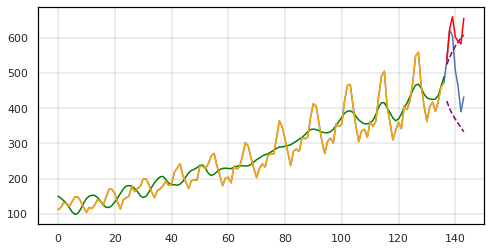

In [32]:
df.plot(y="Passengers", legend=False)  # 目的変数
plt.plot(df_pred[["p5", "p95"]][-7:], linestyle="dashed", color="purple")  # 予測区間
plt.plot(df_pred[["y_pred"]][-7:], color="red")  # 予測値
plt.plot(mu_hat, color="green")  # 状態
plt.plot(y_hat, color="orange")  # 状態+曜日効果
plt.show()

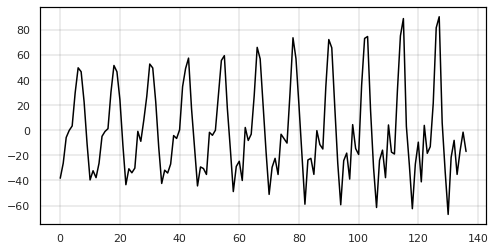

In [33]:
# 月別効果
plt.plot(month_eff_hat, color="black")

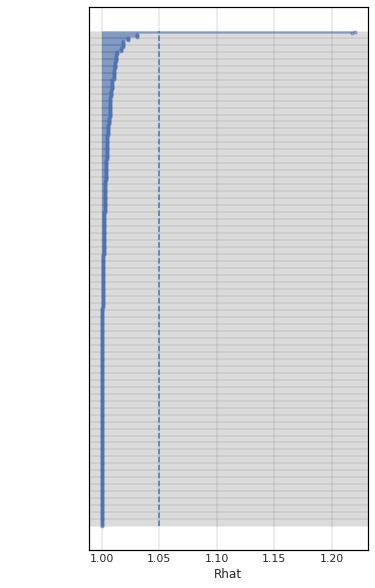

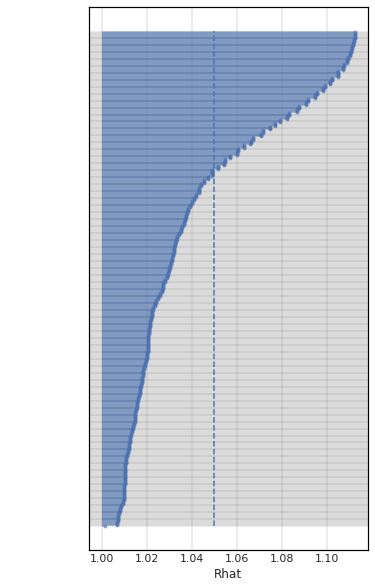

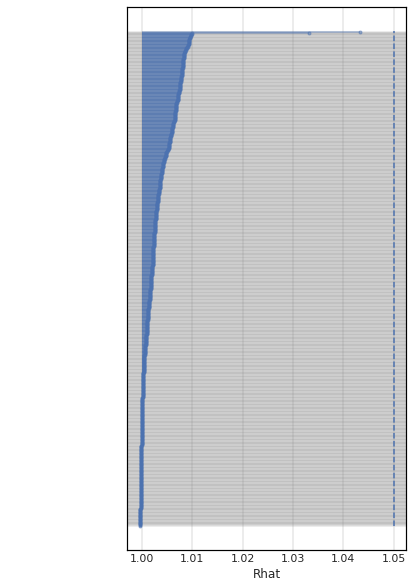

In [34]:
# 収束確認用のRhatのプロット関数
def mcmc_rhat(dataframe, column="Rhat", figsize=(5, 10)):
    plt.figure(figsize=figsize)
    plt.hlines(
        y=dataframe[column].sort_values().index,
        xmin=1,
        xmax=dataframe[column].sort_values(),
        color="b",
        alpha=0.5,
    )
    plt.vlines(x=1.05, ymin=0, ymax=len(dataframe[column]), linestyles="--")
    plt.plot(
        dataframe[column].sort_values().values,
        dataframe[column].sort_values().index,
        marker=".",
        linestyle="None",
        color="b",
        alpha=0.5,
    )
    plt.yticks(color="None")
    plt.tick_params(length=0)
    plt.xlabel(column)
    plt.show()


# 各推定結果のデータフレームを作成
summary_local = pd.DataFrame(
    fit_local_level.summary()["summary"],
    columns=fit_local_level.summary()["summary_colnames"],
    index=fit_local_level.summary()["summary_rownames"],
)
summary_smooth = pd.DataFrame(
    fit_local_level_smooth.summary()["summary"],
    columns=fit_local_level_smooth.summary()["summary_colnames"],
    index=fit_local_level_smooth.summary()["summary_rownames"],
)
summary_smooth_season = pd.DataFrame(
    fit_local_level_smooth_season.summary()["summary"],
    columns=fit_local_level_smooth_season.summary()["summary_colnames"],
    index=fit_local_level_smooth_season.summary()["summary_rownames"],
)

# プロット
mcmc_rhat(summary_local)
mcmc_rhat(summary_smooth)
mcmc_rhat(summary_smooth_season)

array([[<AxesSubplot:title={'center':'s_y'}>,
        <AxesSubplot:title={'center':'s_y'}>],
       [<AxesSubplot:title={'center':'s_mu'}>,
        <AxesSubplot:title={'center':'s_mu'}>],
       [<AxesSubplot:title={'center':'s_month'}>,
        <AxesSubplot:title={'center':'s_month'}>]], dtype=object)

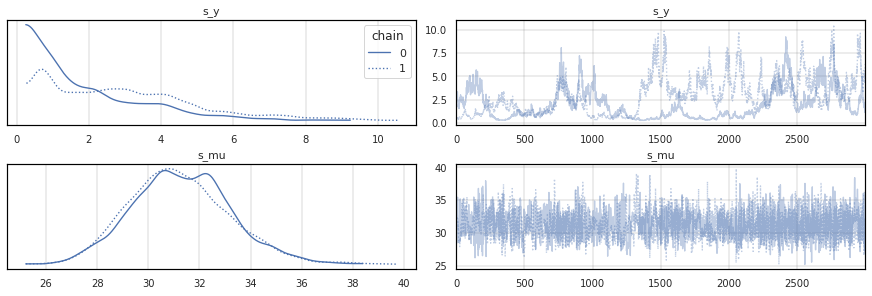

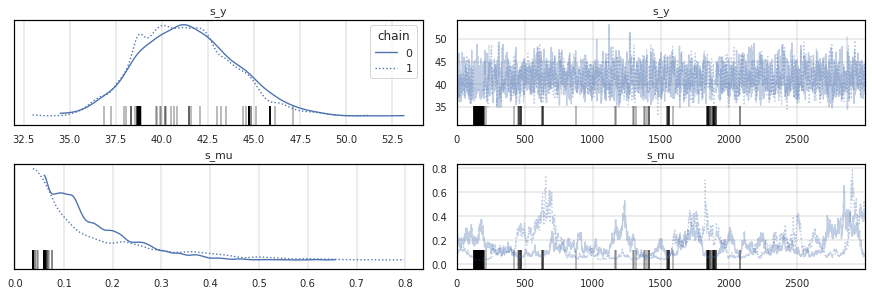

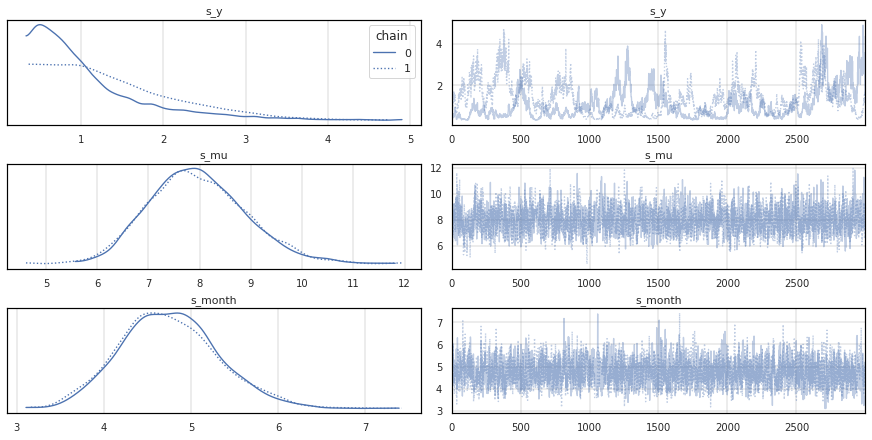

In [35]:
# トレースプロット
arviz.plot_trace(fit_local_level, var_names=["s_y", "s_mu"], legend=True)
arviz.plot_trace(fit_local_level_smooth, var_names=["s_y", "s_mu"], legend=True)
arviz.plot_trace(
    fit_local_level_smooth_season, var_names=["s_y", "s_mu", "s_month"], legend=True
)

### 推定された状態の図示

In [36]:
# MCMCサンプルの取得
mcmc_sample_ll = fit_local_level.extract()
mcmc_sample_lls = fit_local_level_smooth.extract()
mcmc_sample_llss = fit_local_level_smooth_season.extract()

In [37]:
# 全時刻の95%ベイズ信用区間と中央値
# パラメータを指定
state_name = "mu"

# 2.5・50・97.5パーセンタイルの値を
# 入れるためのデータフレームを作成
result_ll = pd.DataFrame(np.zeros([len(df), 3]))
result_lls = pd.DataFrame(np.zeros([len(df), 3]))
result_llss = pd.DataFrame(np.zeros([len(df), 3]))

# 2.5・50・97.5パーセンタイルの値をデータフレームに格納
for i in range(len(df) - M):
    result_ll.iloc[i, :] = np.percentile(
        mcmc_sample_ll[state_name][:, i], q=[2.5, 50, 97.5]
    )
    result_lls.iloc[i, :] = np.percentile(
        mcmc_sample_lls[state_name][:, i], q=[2.5, 50, 97.5]
    )
    result_llss.iloc[i, :] = np.percentile(
        mcmc_sample_llss[state_name][:, i], q=[2.5, 50, 97.5]
    )

# 列名の変更
result_ll.columns = ["lwr", "fit", "upr"]
result_lls.columns = ["lwr", "fit", "upr"]
result_llss.columns = ["lwr", "fit", "upr"]

# 時間情報の追加
result_ll["time"] = df["Month"]
result_lls["time"] = df["Month"]
result_llss["time"] = df["Month"]

# 実測値を追加
result_ll["Passengers"] = df["Passengers"]
result_lls["Passengers"] = df["Passengers"]
result_llss["Passengers"] = df["Passengers"]

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should

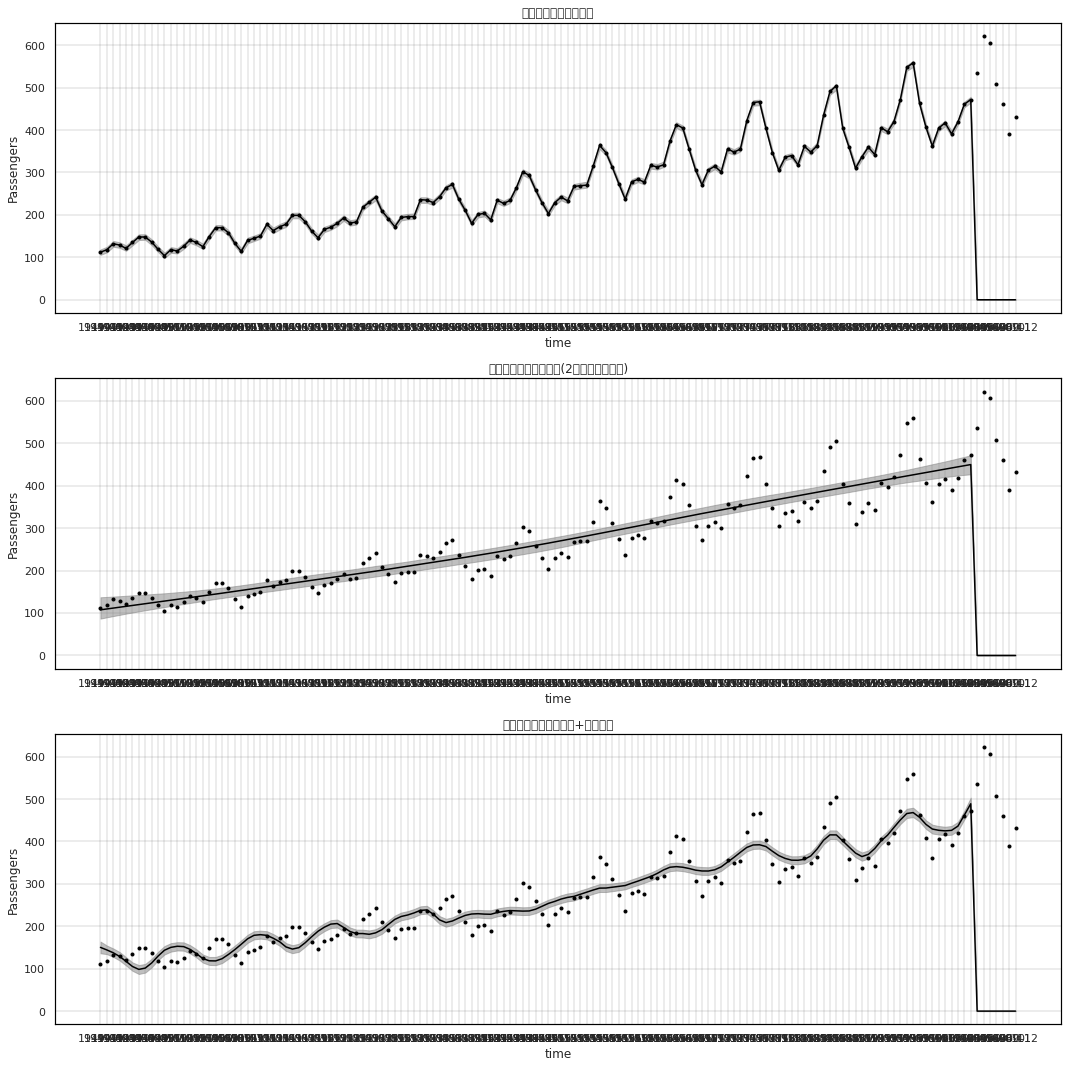

In [38]:
# 描画領域の作成
fig = plt.figure(figsize=(15, 15))

# ローカルレベルモデル
ax_ll = fig.add_subplot(3, 1, 1)
# 実測値をプロット
ax_ll.plot(
    result_ll["time"], result_ll["Passengers"], marker=".", linewidth=0, color="black"
)
# 50パーセンタイルの値をプロット
ax_ll.plot(result_ll["time"], result_ll["fit"], color="black")
# 2.5-97.5%区間の間を埋める
ax_ll.fill_between(
    x=result_ll["time"],
    y1=result_ll["upr"],
    y2=result_ll["lwr"],
    color="gray",
    alpha=0.5,
)
# x軸ラベルの設定
ax_ll.set_xlabel("time")
# y軸ラベルの設定
ax_ll.set_ylabel("Passengers")
# タイトルの設定
ax_ll.set_title("ローカルレベルモデル")

# ローカルレベルモデル(2階差分トレンド)
ax_st = fig.add_subplot(3, 1, 2)
# 実測値をプロット
ax_st.plot(
    result_lls["time"], result_lls["Passengers"], marker=".", linewidth=0, color="black"
)
# 50パーセンタイルの値をプロット
ax_st.plot(result_lls["time"], result_lls["fit"], color="black")
# 2.5-97.5%区間の間を埋める
ax_st.fill_between(
    x=result_lls["time"],
    y1=result_lls["upr"],
    y2=result_lls["lwr"],
    color="gray",
    alpha=0.5,
)
# x軸ラベルの設定
ax_st.set_xlabel("time")
# y軸ラベルの設定
ax_st.set_ylabel("Passengers")
# タイトルの設定
ax_st.set_title("ローカルレベルモデル(2階差分トレンド)")

# ローカルレベルモデル+月別効果
ax_llt = fig.add_subplot(3, 1, 3)
# 実測値をプロット
ax_llt.plot(
    result_llss["time"],
    result_llss["Passengers"],
    marker=".",
    linewidth=0,
    color="black",
)
# 50パーセンタイルの値をプロット
ax_llt.plot(result_llss["time"], result_llss["fit"], color="black")
# 2.5-97.5%区間の間を埋める
ax_llt.fill_between(
    x=result_llss["time"],
    y1=result_llss["upr"],
    y2=result_llss["lwr"],
    color="gray",
    alpha=0.5,
)
# x軸ラベルの設定
ax_llt.set_xlabel("time")
# y軸ラベルの設定
ax_llt.set_ylabel("Passengers")
# タイトルの設定
ax_llt.set_title("ローカルレベルモデル+月別効果")

# グラフの描画
fig.tight_layout()
fig.show()